In [1]:
import numpy as np
import time 
from matplotlib import pyplot as plt
import gpflow
from gpflow.ci_utils import ci_niter
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from TensorNetworkKernels import KernelWithTensorNetwork, KernelSpaceInducingPoints
from sklearn.cluster import KMeans

In [2]:
X_full, Y_full = np.load('./data/elevators/X.npy'), np.load('./data/elevators/y.npy')

x_train, x_test, y_train, y_test = train_test_split(X_full, Y_full, test_size = 0.1, random_state = 0)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state = 0)

scaler_X = StandardScaler()
scaler_Y = StandardScaler()

x_train, x_val, x_test= scaler_X.fit_transform(x_train), scaler_X.transform(x_val), scaler_X.transform(x_test)
y_train, y_val, y_test = scaler_Y.fit_transform(y_train.reshape(-1,1)), scaler_Y.transform(y_val.reshape(-1,1)), scaler_Y.transform(y_test.reshape(-1,1))

# CPD Kernel

In [3]:
cp_rank=10
local_dim=10
batch_size=256

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(x_train.shape[0]).batch(batch_size,
                                                                                            drop_remainder=True).repeat()

kernel = KernelWithTensorNetwork(gpflow.kernels.SquaredExponential(), batch_size=batch_size,
                                 cp_rank=cp_rank,local_dim=local_dim)

M=50 # inducing points 

# Cluster Initialization of Inducing Points 
inducing_variable_kmeans = KMeans(n_clusters=M,random_state=0).fit(x_train)   
Z=inducing_variable_kmeans.cluster_centers_                           
inducing_variable_CP = kernel.CP(Z)
inducing_variable = KernelSpaceInducingPoints(inducing_variable_CP)

model= gpflow.models.SVGP(kernel, gpflow.likelihoods.Gaussian(), inducing_variable , num_data=x_train.shape[0])    
gpflow.set_trainable(model.inducing_variable, True)
model.kernel.CP.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cp__based (CP_Based)         (50, 1)                   1800      
Total params: 1,800
Trainable params: 1,800
Non-trainable params: 0
_________________________________________________________________


Epoch:0, ELBO:-25778.169601673806
Epoch:1000, ELBO:-17221.37143780484
Epoch:2000, ELBO:-14313.106204668407
Epoch:3000, ELBO:-11223.372328841488
Epoch:4000, ELBO:-9243.795038206958
Epoch:5000, ELBO:-7823.015859798684
Epoch:6000, ELBO:-7187.871362202071
Epoch:7000, ELBO:-6830.310268965528
Epoch:8000, ELBO:-6497.921758370342
Epoch:9000, ELBO:-6281.653824470684
Epoch:10000, ELBO:-6131.900150971947
Epoch:11000, ELBO:-5994.771906685749
Epoch:12000, ELBO:-5849.904298927284
Epoch:13000, ELBO:-5771.177371994461
Epoch:14000, ELBO:-5723.384863372726
Epoch:15000, ELBO:-5610.560621419208
Epoch:16000, ELBO:-5548.89385452951
Epoch:17000, ELBO:-5471.136482055787
Epoch:18000, ELBO:-5438.00212961965
Epoch:19000, ELBO:-5379.276587285951
Training Time :95.426992893219
Train MSE:0.12811802306311112, Train ELBO:-5338.426432165823
Validation MSE:0.22777417057146818, Validation ELBO:-10567.728952246825
Test MSE:0.1868898770167622, Validation ELBO:-8388.943956559955


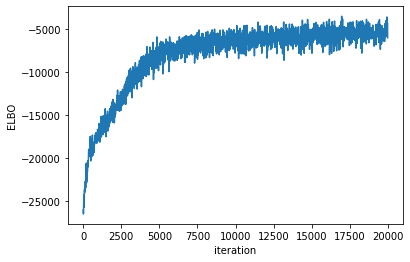

In [20]:
# Training

iterations = ci_niter(20000)

logf = []

train_iter=iter(train_dataset)
training_loss = model.training_loss_closure(train_iter,compile=True)

optimizer = tf.optimizers.Adam(learning_rate=1e-3)
start=time.time()

@tf.function
def optimization_step():
    optimizer.minimize(training_loss, model.trainable_variables)
    
for step in range(iterations):
    optimization_step()    
    if step % 10 == 0:
        elbo = -training_loss().numpy()
        logf.append(elbo)
    if step % 1000==0:
        print("Epoch:{}, ELBO:{}".format(step,model.elbo(data=(x_train,y_train)))) 

end=time.time()
print("Training Time :{}".format(end-start))

plt.plot(np.arange(iterations)[::10], logf)
plt.xlabel("iteration")
_ = plt.ylabel("ELBO")

train_mean, train_var = model.predict_f(x_train) 
train_elbo=model.elbo(data=(x_train,y_train))

train_mse=tf.reduce_mean(tf.losses.MSE(train_mean,y_train))

val_mean, val_var = model.predict_f(x_val)
val_elbo = model.elbo(data=(x_val,y_val))

val_mse=tf.reduce_mean(tf.losses.MSE(val_mean,y_val))

test_mean, val_var = model.predict_f(x_test)
test_elbo = model.elbo(data=(x_test,y_test))

test_mse=tf.reduce_mean(tf.losses.MSE(test_mean,y_test))


print("Train MSE:{}, Train ELBO:{}".format(train_mse,train_elbo))
print("Validation MSE:{}, Validation ELBO:{}".format(val_mse,val_elbo))
print("Test MSE:{}, Validation ELBO:{}".format(test_mse,test_elbo))

# Tensor Network 

In [25]:
def local_feature_mapping(x_train,x_val,x_test,local_dim=2,unit_norm=False):
    
    n_train_samples = x_train.shape[0]
    n_val_samples = x_val.shape[0]
    n_test_samples = x_test.shape[0]
    n_features = x_train.shape[1]

    X_transformed_train_list = []
    X_transformed_val_list = []
    X_transformed_test_list = []
    
    for d in range(local_dim-1):
        X_transformed_train_list.append(x_train**(d+1))
        X_transformed_val_list.append(x_val**(d+1))
        X_transformed_test_list.append(x_test**(d+1))
         
    X_stand_train_list = [np.ones((n_train_samples,n_features))]
    X_stand_val_list = [np.ones((n_val_samples,n_features))]
    X_stand_test_list = [np.ones((n_test_samples,n_features))]
    
    for X_trans_train,X_trans_val,X_trans_test in zip(X_transformed_train_list,X_transformed_val_list,X_transformed_test_list):
         
      X_stand_train_list.append(X_trans_train)
      X_stand_val_list.append(X_trans_val) 
      X_stand_test_list.append(X_trans_test)
        
    x_train_processed= np.transpose(X_stand_train_list,(1, 2, 0))
    x_val_processed= np.transpose(X_stand_val_list,(1, 2, 0))
    x_test_processed = np.transpose(X_stand_test_list,(1, 2, 0))

    if(unit_norm==True):
      norms_train = np.sqrt(np.sum(x_train_processed**2,axis=-1,keepdims=True))
      x_train_processed = np.divide(x_train_processed,norms_train)

      norms_val = np.sqrt(np.sum(x_val_processed**2,axis=-1,keepdims=True))
      x_val_processed = np.divide(x_val_processed,norms_val)
    
      norms_test = np.sqrt(np.sum(x_test_processed**2,axis=-1,keepdims=True))
      x_test_processed = np.divide(x_test_processed,norms_test)

    return x_train_processed, x_val_processed, x_test_processed      


Epoch 1/300
53/53 [==============================] - 0s 5ms/step - loss: 1.0000 - val_loss: 0.9825
Epoch 2/300
53/53 [==============================] - 0s 3ms/step - loss: 1.0000 - val_loss: 0.9825
Epoch 3/300
53/53 [==============================] - 0s 2ms/step - loss: 1.0000 - val_loss: 0.9825
Epoch 4/300
53/53 [==============================] - 0s 3ms/step - loss: 1.0000 - val_loss: 0.9825
Epoch 5/300
53/53 [==============================] - 0s 2ms/step - loss: 1.0000 - val_loss: 0.9825
Epoch 6/300
53/53 [==============================] - 0s 2ms/step - loss: 1.0000 - val_loss: 0.9825
Epoch 7/300
53/53 [==============================] - 0s 2ms/step - loss: 1.0000 - val_loss: 0.9825
Epoch 8/300
53/53 [==============================] - 0s 2ms/step - loss: 1.0000 - val_loss: 0.9825
Epoch 9/300
53/53 [==============================] - 0s 2ms/step - loss: 1.0000 - val_loss: 0.9825
Epoch 10/300
53/53 [==============================] - 0s 2ms/step - loss: 1.0000 - val_loss: 0.9825
Epoch 11/

53/53 [==============================] - 0s 2ms/step - loss: 0.4887 - val_loss: 0.5495
Epoch 84/300
53/53 [==============================] - 0s 2ms/step - loss: 0.4846 - val_loss: 0.5476
Epoch 85/300
53/53 [==============================] - 0s 2ms/step - loss: 0.4812 - val_loss: 0.5346
Epoch 86/300
53/53 [==============================] - 0s 2ms/step - loss: 0.4718 - val_loss: 0.5272
Epoch 87/300
53/53 [==============================] - 0s 2ms/step - loss: 0.4601 - val_loss: 0.5076
Epoch 88/300
53/53 [==============================] - 0s 2ms/step - loss: 0.4476 - val_loss: 0.4957
Epoch 89/300
53/53 [==============================] - 0s 2ms/step - loss: 0.4334 - val_loss: 0.4722
Epoch 90/300
53/53 [==============================] - 0s 2ms/step - loss: 0.4205 - val_loss: 0.4584
Epoch 91/300
53/53 [==============================] - 0s 2ms/step - loss: 0.4107 - val_loss: 0.4507
Epoch 92/300
53/53 [==============================] - 0s 2ms/step - loss: 0.4017 - val_loss: 0.4408
Epoch 93/300


53/53 [==============================] - 0s 2ms/step - loss: 0.1843 - val_loss: 0.2248
Epoch 246/300
53/53 [==============================] - 0s 2ms/step - loss: 0.1834 - val_loss: 0.2257
Epoch 247/300
53/53 [==============================] - 0s 2ms/step - loss: 0.1845 - val_loss: 0.2256
Epoch 248/300
53/53 [==============================] - 0s 2ms/step - loss: 0.1834 - val_loss: 0.2224
Epoch 249/300
53/53 [==============================] - 0s 2ms/step - loss: 0.1829 - val_loss: 0.2247
Epoch 250/300
53/53 [==============================] - 0s 3ms/step - loss: 0.1826 - val_loss: 0.2214
Epoch 251/300
53/53 [==============================] - 0s 3ms/step - loss: 0.1823 - val_loss: 0.2216
Epoch 252/300
53/53 [==============================] - 0s 2ms/step - loss: 0.1829 - val_loss: 0.2220
Epoch 253/300
53/53 [==============================] - 0s 3ms/step - loss: 0.1824 - val_loss: 0.2206
Epoch 254/300
53/53 [==============================] - 0s 2ms/step - loss: 0.1823 - val_loss: 0.2219
Epoc

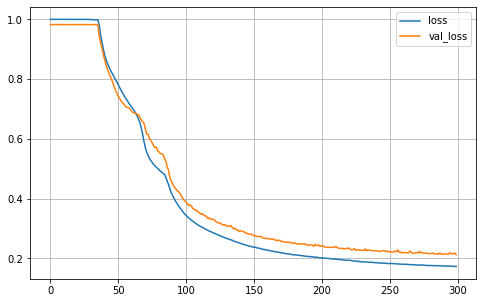

Training time:36.26968502998352
52/52 [==============================] - 0s 604us/step - loss: 0.2050
Test MSE:0.2050376683473587


In [26]:
from CP_Model import CP_Based
from tensorflow.keras.models import Sequential
import pandas as pd 
from tensorflow import keras 

x_train_processed,x_val_processed,x_test_processed=local_feature_mapping(x_train,x_val,x_test,local_dim=local_dim,unit_norm=True)

model=Sequential()
model.add(CP_Based(units=1,activation=None,cp_rank=cp_rank,local_dim=local_dim,

                    initializer=keras.initializers.TruncatedNormal(mean=0, stddev=0.5)))

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer, loss=tf.keras.losses.MeanSquaredError())

start = time.time()
history=model.fit(x_train_processed, y_train, epochs=300, batch_size=256,validation_data=(x_val_processed,y_val))
end = time.time()
model.summary()

train_loss=min(history.history['loss'])
val_loss=min(history.history['val_loss'])
print('train loss:{}'.format(train_loss))
print('validation loss:{}'.format(val_loss))

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

print('Training time:{}'.format(end-start))
print('Test MSE:{}'.format(model.evaluate(x_test_processed,y_test)))



# Deep Kernel

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (50, 35)                  665       
_________________________________________________________________
dense_1 (Dense)              (50, 30)                  1080      
_________________________________________________________________
dense_2 (Dense)              (50, 1)                   31        
Total params: 1,776
Trainable params: 1,776
Non-trainable params: 0
_________________________________________________________________
Epoch:0, ELBO:-25769.788128490498
Epoch:1000, ELBO:-10233.48376144745
Epoch:2000, ELBO:-5930.6097156788765
Epoch:3000, ELBO:-4598.754133208631
Epoch:4000, ELBO:-4255.853674166433
Epoch:5000, ELBO:-4218.445939012285
Epoch:6000, ELBO:-4012.1237002988396
Epoch:7000, ELBO:-3921.513854480044
Epoch:8000, ELBO:-4008.4707961663776
Epoch:9000, ELBO:-3854.7141478664907
Epoch:10000, ELBO:-3

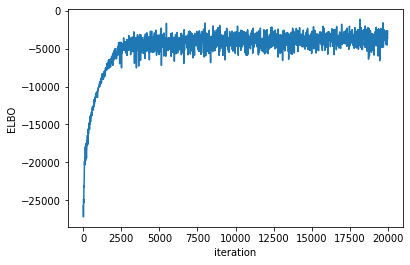

In [4]:
from DeepKernels import DeepKernel, KernelSpaceInducingPoints

batch_size=256
kernel = DeepKernel(gpflow.kernels.SquaredExponential(), batch_size=batch_size)

M=50 # inducing points 

# Cluster Initialization of Inducing Points 
inducing_variable_kmeans = KMeans(n_clusters=M,random_state=0).fit(x_train)   
Z=inducing_variable_kmeans.cluster_centers_                           
inducing_variable_CP = kernel.CP(Z)
inducing_variable = KernelSpaceInducingPoints(inducing_variable_CP)


model= gpflow.models.SVGP(kernel, gpflow.likelihoods.Gaussian(), inducing_variable , num_data=x_train.shape[0])    
gpflow.set_trainable(model.inducing_variable, True)
model.kernel.CP.summary()

# Training

iterations = ci_niter(20000)

logf = []

train_iter=iter(train_dataset)
training_loss = model.training_loss_closure(train_iter,compile=True)

optimizer = tf.optimizers.Adam(learning_rate=1e-3)
start=time.time()

@tf.function
def optimization_step():
    optimizer.minimize(training_loss, model.trainable_variables)
    
for step in range(iterations):
    optimization_step()    
    if step % 10 == 0:
        elbo = -training_loss().numpy()
        logf.append(elbo)
    if step % 1000==0:
        print("Epoch:{}, ELBO:{}".format(step,model.elbo(data=(x_train,y_train)))) 

end=time.time()
print("Training Time :{}".format(end-start))

plt.plot(np.arange(iterations)[::10], logf)
plt.xlabel("iteration")
_ = plt.ylabel("ELBO")

train_mean, train_var = model.predict_f(x_train) 
train_elbo=model.elbo(data=(x_train,y_train))

train_mse=tf.reduce_mean(tf.losses.MSE(train_mean,y_train))

val_mean, val_var = model.predict_f(x_val)
val_elbo = model.elbo(data=(x_val,y_val))

val_mse=tf.reduce_mean(tf.losses.MSE(val_mean,y_val))

test_mean, val_var = model.predict_f(x_test)
test_elbo = model.elbo(data=(x_test,y_test))

test_mse=tf.reduce_mean(tf.losses.MSE(test_mean,y_test))


print("Train MSE:{}, Train ELBO:{}".format(train_mse,train_elbo))
print("Validation MSE:{}, Validation ELBO:{}".format(val_mse,val_elbo))
print("Test MSE:{}, Validation ELBO:{}".format(test_mse,test_elbo))

# Gaussian Process with ARD RBF Kernel 

Train MSE:0.21918109755069434, Train ELBO:-10266.669151901753
Validation MSE:0.2529329664430518, Validation ELBO:-11056.848680034946
Test MSE:0.2388905794576891, Validation ELBO:-10717.160660360409


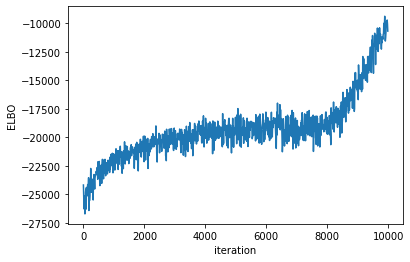

In [9]:
kernel= gpflow.kernels.SquaredExponential(lengthscales=[0.1]*x_train.shape[1]) #  ARD

M=50 # inducing points 

# Cluster Initialization of Inducing Points 
inducing_variable_kmeans = KMeans(n_clusters=M,random_state=0).fit(x_train)   
Z=inducing_variable_kmeans.cluster_centers_    

model = gpflow.models.SVGP(kernel, gpflow.likelihoods.Gaussian(), Z, num_data=x_train.shape[0])
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).repeat().shuffle(x_train.shape[0])

minibatch_size = 256
gpflow.set_trainable(model.inducing_variable, True)


def run_adam(model, iterations):
    """
    Utility function running the Adam optimizer

    :param model: GPflow model
    :param interations: number of iterations
    """
    # Create an Adam Optimizer action
    logf = []
    train_iter = iter(train_dataset.batch(minibatch_size))
    training_loss = model.training_loss_closure(train_iter, compile=True)
    optimizer = tf.optimizers.Adam(learning_rate=1e-3)

    @tf.function
    def optimization_step():
        optimizer.minimize(training_loss, model.trainable_variables)

    for step in range(iterations):
        optimization_step()
        if step % 10 == 0:
            elbo = -training_loss().numpy()
            logf.append(elbo)
    return logf

maxiter = ci_niter(10000)

logf = run_adam(model, maxiter)
plt.plot(np.arange(maxiter)[::10], logf)
plt.xlabel("iteration")
_ = plt.ylabel("ELBO")

train_mean, train_var = model.predict_f(x_train) 
train_elbo=model.elbo(data=(x_train,y_train))

train_mse=tf.reduce_mean(tf.losses.MSE(train_mean,y_train))

val_mean, val_var = model.predict_f(x_val)
val_elbo = model.elbo(data=(x_val,y_val))

val_mse=tf.reduce_mean(tf.losses.MSE(val_mean,y_val))

test_mean, val_var = model.predict_f(x_test)
test_elbo = model.elbo(data=(x_test,y_test))

test_mse=tf.reduce_mean(tf.losses.MSE(test_mean,y_test))


print("Train MSE:{}, Train ELBO:{}".format(train_mse,train_elbo))
print("Validation MSE:{}, Validation ELBO:{}".format(val_mse,val_elbo))
print("Test MSE:{}, Validation ELBO:{}".format(test_mse,test_elbo))